# Supervised Learning Project: Optimización de rendimiento en competencias de ultra trail running

## Introducción

### Motivation y Justificación

#### ¿Qué es el running?

El ***running*** es una actividad física que implica desplazar el cuerpo una cierta distancia de manera repetida sobre varios intervalos de tiempo hasta realizar un recorrido. Esto implica la activación de muchos músculos que, dependiendo de la condición física y entrenamiento de la persona y en menor medida de otros factores como el clima y el desnivel, permitirá hacer el recorrido en mayor o menor tiempo. Visto de otra manera permitirá recorrer mayor o menor distancia, en un intervalo de tiempo definido. El *running* se practica por lo general en vias asfaltadas con poco o ningún desnivel por lo que el resultado de la actividad es muy **predecible** basado en la condición física de la persona y entrenamiento.

![image](./images/running.png)
*Generated with ChatGPT with prompt "Generate an image of a runner athlete running on a street, viewed from the side with an image of an analog stopwatch above his head, and a ghosted image of the same runner about 10 meters ahead with the stopwatch above his head having advanced a few seconds. Draw a metered line below the runner and it's ghosted image indicating the displaced space between them."*

#### ¿Qué es el trail running?

El ***trail running*** es una actividad física al igual que el *running*, implica desplazar el cuerpo una distancia de manera repetida pero que se diferencia del *running* en que la actividad se realiza usualmente en senderos y caminos de tercer orden. La actividad del **trail running** implica muchas condiciones que cambian durante el transcurso de la actividad (morfología del terreno, desnivel, condiciones climáticas) que dificultan predecir el resultado de la actividad. Estas variables adicionales representan un desafío para una planificación estratégica que maximice el rendimiento del deportista durante el recorrido.

![image](./images/trail-running.png)
*Generated with ChatGPT with prompt "Generate an image consisting on 2 images side-by-side. On the left hand side, draw a trail runner viewed from the side power walking uphill on a mountain trail on a steep hill on a sunny day with clear sky. On the right hand side, draw the same trail runner using a rain jacket, running downhill on a rocky trail on a rainy day with cloudy sky."*

#### ¿Qué es el *ultra* trail running?

El ***ultra trail running*** es una actividad de *ultra resistencia*, que se entiende como una actividad que tiene una duración de más de 4 horas, pudiendo extenderse a varios días incluso. Algunas fuentes(https://www.dynafit.com/what-is-trail-running) definen a la actividad por su distancia, superando la distancia de una maraton (42.195 km) y que en el caso del *trail running*, es común que realizar recorridos que superen esta distancia supere también las 4 horas pero dependerá del desnivel y de la capacidad del atleta.

En el *ultra trail running*, las condiciones climáticas, entre otros factores externos, tienen una mayor probabilidad de cambiar debido a la prolongada duración de la actividad teniendo que por lo general ajustar la estrategia sobre la marcha. A diferencia de deportes de resistencia o de corta duración, los deportes de ultra resistencia presentan un desafío adicional debido a los cambios fisiológicos que sufre el cuerpo del atleta durante la práctica prolongada de la actividad. El gasto energético constante y la pérdida de electrolitos tienden a generar un déficit que tiene que ser compensado con cierta frecuencia por lo que la nutrición, antes y durante la actividad, es importante para obtener un buen resultado. El ritmo o intensidad a la que se lleva a cabo la actividad también tiene que ser moderada para evitar la acumulación execisva de ácido láctico que puede llevar a niveles de fatiga exesivos e ir en contra del desempeño del deportista. 

#### ¿Por qué es importante?

En la práctica del *ultra trail running* es importante tener una noción del tiempo estimado en que tomará realizar un recorrido, este se estima usualmente con un gran margen de error en base a experiencias anteriores en recorridos similares. Es común tomar este tiempo estimado para realizar una planificación estratégica que, sobre todo a nivel competitivo, permitirá máximizar los resultados, es decir, poder realizar el recorrido en el menor tiempo posible.

El *trail running* y sobre todo el *ultra trail running*, son actividades que por lo general se practican en auto-suficiencia, es decir, que es responsabilidad del practicante llevar el equipo y materiales necesarios para llevar a cabo con éxito el recorrido. Esto incluye llevar consigo la cantidad de alimentos y líquidos necesarios para reponer el gasto energético y perdida de electrolítos antes mencionadas. Parte de la estrategia llevar la cantidad justa de alimentos y líquidos entre puntos de control durante la competencia. Llevar más de lo necesario conlleva a cargar más peso y por ende un mayor gasto energético y mayor tiempo en completar la distancia. Por otro lado, llevar menos de lo necesario conlleva el riesgo de quedarse sin alimentos o liquidos durante el recorrido con el peligro de sufrir una descompensación que de prolongarse por mucho tiempo puede tener consecuencias potencialmente graves para el deportista.

Tener un tiempo estimado de recorrido tanto total como por segmentos, ayuda al deportista a que tener una noción del ritmo que deberia llevar sobre cada segmento. Por ejemplo, si después de un determinado tiempo de haber iniciado la actividad, el deportista ha recorrido una distancia menor de la estimada sobre ese tiempo se podría decir que esta llevando un ritmo muy comodo y que podría elevar su ritmo de carrera para hacer un menor tiempo. Asi mismo, si despues de un determinado tiempo de haber iniciado el recorrido, el deportista se encuentra por delante de la posición estimada a ese tiempo y dependiendo del recorrido restante podría bajar el ritmo para evitar la acumulación de ácido láctico y el desgaste general.

## EDA (Exploratory Data Analysis)

### Data preprocessing

Antes que el EDA pueda ser filtrado, los datos necesitos ser filtrados y preprocesados extrayendo las sesiones de entrenamiento de la carpeta `full-data` que contiene *todas* las sesiones de entrenamiento entre disciplinas y duraciones.

El enfoque de este proyecto esta en analizar las sesiones de entrenamientos de trail running que tienen una duración de almenos de 3 horas. Las sesiones de entrenamiento vienen en formato JSON format, que luego de procesar las métricas de interés se almacenarán en formato CSV para su procesamiento tabular dentro de la carpeta `long-tr-data`

In [2]:
# Install rdflib to use isodate
%pip install rdflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 6.0 MB/s eta 0:00:00a 0:00:01


In [5]:
import traceback
import pandas as pd
import os
import json
import isodate
# from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import time
import sys

# Create the output directory if it doesn't exist
# output_dir = "./data/long-tr-data"
output_dir = "/home/eaguayo/workspace/ml-project/data/long-tr-data"
os.makedirs(output_dir, exist_ok=True)

# Iterate through all files in the ./full-data folder
# input_dir = "./data/full-data"
input_dir = "/home/eaguayo/workspace/ml-project/data/full-data"
count = 0
skipped = 0
start_hours = 4

def process_file(file_name):
    file_path = f"{input_dir}/{file_name}"
    try:
        with open(file_path, "r") as f:
            data = json.load(f)

        exercise = data.get("exercises", [])[0]

        # 1. check if the sport corresponds to trail running and if the duration is greater than 3 hours
        #    also check if the file has already been processed
        sport = exercise.get("sport")
        duration_iso = exercise.get("duration")
        duration = isodate.parse_duration(duration_iso).total_seconds()

        if sport != "TRAIL_RUNNING" or duration < start_hours * 3600:
            return False

        # Skip processing if the output file already exists
        output_file_name = f"{output_dir}/{file_name.replace('.json', '.csv')}"
        if os.path.exists(output_file_name):
            return False

        # 2. Extract available data ---
        print(f"Processing file: {file_name}")
        start_time = time.time()

        sample_features = [
            "heartRate",
            "altitude",
            "distance",
            "temperature",
            "cadence",
            "speed",
        ]
        samples = exercise.get("samples", {})

        # Initialize main dataframe with heart rate samples
        df = pd.DataFrame(
            [
                {
                    "timestamp": pd.to_datetime(sample["dateTime"]),
                    "heartRate": sample["value"] if "value" in sample else None,
                }
                for sample in samples.get("heartRate", [])
            ]
        )

        # Date
        df["date"] = df["timestamp"].dt.date

        # Calculate timestamp diff and add it to the dataframe as a new column
        df["duration"] = df["timestamp"].diff().dt.total_seconds().cumsum().fillna(0)

        # Process and merge other sample types
        for sample_feature in sample_features[1:]:  # Skip heartRate (already in df)
            sample_data = samples.get(sample_feature, [])
            if not sample_data:
                continue
            temp_df = pd.DataFrame(
                [
                    {
                        "timestamp": pd.to_datetime(sample["dateTime"]),
                        sample_feature: sample["value"] if "value" in sample else None,
                    }
                    for sample in sample_data
                ]
            )
            if sample_feature == "distance":
                # Calculate distance difference
                temp_df["distance_diff"] = temp_df[sample_feature].diff().fillna(0)
            if sample_feature == "altitude":
                # Smooth altitude data
                temp_df[sample_feature] = temp_df[sample_feature].rolling(window=5, min_periods=1, center=True).mean()
                # Calculate elevation difference
                temp_df["elevation_diff"] = temp_df[sample_feature].diff().fillna(0)

            if sample_feature in df.columns:
                # Within a second is very likely that the same sample is repeated
                temp_df[sample_feature] = temp_df[sample_feature].fillna(method='ffill')
            df = pd.merge(df, temp_df, on="timestamp", how="left")

        # Save the dataframe to a CSV file
        df.to_csv(output_file_name, index=False)
        end_time = time.time()
        print(f"Saved processed data to: {output_file_name}")
        print(f"Processing time for {file_name}: {end_time - start_time:.2f} seconds")
        return True
    except FileNotFoundError:
        print(f"Error: File not found at path: {file_name}")
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in file: {file_name}")
    except Exception as e:
        exc_type, exc_value, exc_traceback = sys.exc_info()
        print(f"An unexpected error occurred in file: {file_name}")
        print(f"With error {exc_type}: {exc_value}")
        print("Traceback:")
        traceback.print_exception(exc_type, exc_value, exc_traceback)
    return False


# Get the list of files
files = os.listdir(input_dir)

# Process files sequentially
for file_name in tqdm(files):
    if process_file(file_name):
        count += 1
        # break # Uncomment to process only the first file for testing
    else:
        skipped += 1

# Process files in parallel with a progress bar
# TODO: Does not seem to work well from vscode ipynb with local kernel 
#   or remote jupyter server runtime. Maybe split to a separate .py script file.
# with ThreadPoolExecutor(max_workers=8) as executor:
#     futures = {executor.submit(process_file, file_name): file_name for file_name in files}
#     for future in tqdm(as_completed(futures), total=len(futures)):
#         if future.result():
#             count += 1

print(f"Skipped {skipped} files.")
print(f"Processed {count} files.")

  0%|          | 4/1468 [00:00<00:39, 36.95it/s]

  1%|          | 11/1468 [00:00<00:26, 54.97it/s]

Processing file: training-session-2023-03-18-7606603203-e51b3f6f-5e70-4fbf-b306-060ab13c8302.json


  1%|          | 13/1468 [01:10<3:12:46,  7.95s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-03-18-7606603203-e51b3f6f-5e70-4fbf-b306-060ab13c8302.csv
Processing time for training-session-2023-03-18-7606603203-e51b3f6f-5e70-4fbf-b306-060ab13c8302.json: 70.14 seconds
Processing file: training-session-2021-05-16-6063407634-d69f9ab5-57fc-450a-be50-8a1d947c9014.json


  1%|▏         | 20/1468 [02:07<3:14:52,  8.07s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-05-16-6063407634-d69f9ab5-57fc-450a-be50-8a1d947c9014.csv
Processing time for training-session-2021-05-16-6063407634-d69f9ab5-57fc-450a-be50-8a1d947c9014.json: 57.10 seconds
Processing file: training-session-2023-04-29-7632993630-e41b72b8-788d-4c77-a8ea-6fea673970ea.json


  2%|▏         | 29/1468 [03:02<2:35:24,  6.48s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-04-29-7632993630-e41b72b8-788d-4c77-a8ea-6fea673970ea.csv
Processing time for training-session-2023-04-29-7632993630-e41b72b8-788d-4c77-a8ea-6fea673970ea.json: 54.28 seconds


  2%|▏         | 34/1468 [03:02<1:42:40,  4.30s/it]

Processing file: training-session-2024-07-20-7923977820-38ab61c5-0716-4bfb-a0be-1c0e4b550b8a.json


  3%|▎         | 37/1468 [03:45<2:27:22,  6.18s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-07-20-7923977820-38ab61c5-0716-4bfb-a0be-1c0e4b550b8a.csv
Processing time for training-session-2024-07-20-7923977820-38ab61c5-0716-4bfb-a0be-1c0e4b550b8a.json: 43.02 seconds
Processing file: training-session-2021-09-11-6510697629-1bfe3366-c3f7-4af0-97b3-46c677a2c060.json


  3%|▎         | 46/1468 [04:28<1:49:26,  4.62s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-09-11-6510697629-1bfe3366-c3f7-4af0-97b3-46c677a2c060.csv
Processing time for training-session-2021-09-11-6510697629-1bfe3366-c3f7-4af0-97b3-46c677a2c060.json: 42.30 seconds
Processing file: training-session-2021-07-10-6256467174-827980f8-d8fc-4c10-b886-507a2bac05b4.json


  4%|▎         | 52/1468 [06:04<3:14:03,  8.22s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-07-10-6256467174-827980f8-d8fc-4c10-b886-507a2bac05b4.csv
Processing time for training-session-2021-07-10-6256467174-827980f8-d8fc-4c10-b886-507a2bac05b4.json: 95.75 seconds
Processing file: training-session-2021-06-20-6180471154-a1051946-edf3-4ea3-89ad-dd0588d9b573.json


  4%|▍         | 62/1468 [06:49<2:25:15,  6.20s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-06-20-6180471154-a1051946-edf3-4ea3-89ad-dd0588d9b573.csv
Processing time for training-session-2021-06-20-6180471154-a1051946-edf3-4ea3-89ad-dd0588d9b573.json: 45.14 seconds
Processing file: training-session-2022-12-17-7552167482-eb1bc1f5-2ed0-42c5-9726-7d137ed20bbf.json


  5%|▍         | 68/1468 [07:40<2:30:43,  6.46s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-12-17-7552167482-eb1bc1f5-2ed0-42c5-9726-7d137ed20bbf.csv
Processing time for training-session-2022-12-17-7552167482-eb1bc1f5-2ed0-42c5-9726-7d137ed20bbf.json: 50.06 seconds


  5%|▌         | 78/1468 [07:40<1:08:31,  2.96s/it]

Processing file: training-session-2023-09-16-7732317675-e6ba8a6d-a4e8-4037-ad52-e4395b90f9e2.json


  6%|▌         | 82/1468 [09:16<3:11:02,  8.27s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-09-16-7732317675-e6ba8a6d-a4e8-4037-ad52-e4395b90f9e2.csv
Processing time for training-session-2023-09-16-7732317675-e6ba8a6d-a4e8-4037-ad52-e4395b90f9e2.json: 95.85 seconds
Processing file: training-session-2022-11-11-7525661066-bdfa169b-db1a-42fb-a626-4977ea4ef9b7.json


  6%|▌         | 87/1468 [12:31<6:54:45, 18.02s/it] 

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-11-11-7525661066-bdfa169b-db1a-42fb-a626-4977ea4ef9b7.csv
Processing time for training-session-2022-11-11-7525661066-bdfa169b-db1a-42fb-a626-4977ea4ef9b7.json: 193.87 seconds


  7%|▋         | 107/1468 [12:31<1:16:32,  3.37s/it]

Processing file: training-session-2024-06-15-7901192938-dbec766c-3607-4f5f-b977-06aa322988b1.json


  8%|▊         | 120/1468 [14:10<1:49:02,  4.85s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-06-15-7901192938-dbec766c-3607-4f5f-b977-06aa322988b1.csv
Processing time for training-session-2024-06-15-7901192938-dbec766c-3607-4f5f-b977-06aa322988b1.json: 98.11 seconds


 10%|▉         | 141/1468 [14:10<29:58,  1.36s/it]  

Processing file: training-session-2024-02-11-7817578157-db1a61bf-6bbb-416f-acd5-4473e72a3f22.json


 10%|█         | 152/1468 [14:54<49:15,  2.25s/it]  

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-02-11-7817578157-db1a61bf-6bbb-416f-acd5-4473e72a3f22.csv
Processing time for training-session-2024-02-11-7817578157-db1a61bf-6bbb-416f-acd5-4473e72a3f22.json: 43.30 seconds


 12%|█▏        | 174/1468 [14:54<12:26,  1.73it/s]

Processing file: training-session-2021-07-31-6330675234-a8a02e73-8a33-4a6a-89f5-e249737e1d29.json


 12%|█▏        | 176/1468 [15:49<1:30:04,  4.18s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-07-31-6330675234-a8a02e73-8a33-4a6a-89f5-e249737e1d29.csv
Processing time for training-session-2021-07-31-6330675234-a8a02e73-8a33-4a6a-89f5-e249737e1d29.json: 54.15 seconds
Processing file: training-session-2023-06-25-7670927095-6e04530c-f4c4-45a4-8067-f2698d568e44.json


 13%|█▎        | 184/1468 [16:36<1:43:21,  4.83s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-06-25-7670927095-6e04530c-f4c4-45a4-8067-f2698d568e44.csv
Processing time for training-session-2023-06-25-7670927095-6e04530c-f4c4-45a4-8067-f2698d568e44.json: 47.01 seconds


 13%|█▎        | 198/1468 [16:37<31:14,  1.48s/it]  

Processing file: training-session-2023-04-01-7617235798-5e06759b-fadb-4998-902a-f617b8e5fd58.json


 14%|█▍        | 205/1468 [17:31<1:17:49,  3.70s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-04-01-7617235798-5e06759b-fadb-4998-902a-f617b8e5fd58.csv
Processing time for training-session-2023-04-01-7617235798-5e06759b-fadb-4998-902a-f617b8e5fd58.json: 53.50 seconds
Processing file: training-session-2022-01-02-6870048274-cb0318a2-329f-45c0-b41d-a45eb3c76eae.json


 14%|█▍        | 207/1468 [18:23<2:41:56,  7.71s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-01-02-6870048274-cb0318a2-329f-45c0-b41d-a45eb3c76eae.csv
Processing time for training-session-2022-01-02-6870048274-cb0318a2-329f-45c0-b41d-a45eb3c76eae.json: 52.13 seconds
Processing file: training-session-2022-09-25-7505259880-c6e571d4-0d27-459a-996a-bb657781848b.json


 15%|█▍        | 215/1468 [19:22<2:18:32,  6.63s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-09-25-7505259880-c6e571d4-0d27-459a-996a-bb657781848b.csv
Processing time for training-session-2022-09-25-7505259880-c6e571d4-0d27-459a-996a-bb657781848b.json: 58.42 seconds
Processing file: training-session-2025-04-20-8097526312-db510516-82ad-4e51-9f54-c1f8f4fa9204.json


 15%|█▌        | 224/1468 [20:08<1:42:17,  4.93s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2025-04-20-8097526312-db510516-82ad-4e51-9f54-c1f8f4fa9204.csv
Processing time for training-session-2025-04-20-8097526312-db510516-82ad-4e51-9f54-c1f8f4fa9204.json: 46.07 seconds


 16%|█▌        | 231/1468 [20:08<1:00:56,  2.96s/it]

Processing file: training-session-2024-12-07-8013382410-7f4a69f9-21eb-4202-8c19-e86eddea404b.json


 16%|█▋        | 239/1468 [21:08<1:28:05,  4.30s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-12-07-8013382410-7f4a69f9-21eb-4202-8c19-e86eddea404b.csv
Processing time for training-session-2024-12-07-8013382410-7f4a69f9-21eb-4202-8c19-e86eddea404b.json: 59.62 seconds


 17%|█▋        | 244/1468 [21:08<1:00:21,  2.96s/it]

Processing file: training-session-2021-08-22-6412871504-cb5b54f1-6dcf-47bf-9945-355144bb16e5.json


 17%|█▋        | 252/1468 [21:46<1:04:41,  3.19s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-08-22-6412871504-cb5b54f1-6dcf-47bf-9945-355144bb16e5.csv
Processing time for training-session-2021-08-22-6412871504-cb5b54f1-6dcf-47bf-9945-355144bb16e5.json: 37.47 seconds


 18%|█▊        | 265/1468 [21:46<26:36,  1.33s/it]  

Processing file: training-session-2023-07-01-7677360742-8982365b-0fcf-4ccc-836e-692237922a6a.json


 19%|█▊        | 272/1468 [22:30<55:00,  2.76s/it]  

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-07-01-7677360742-8982365b-0fcf-4ccc-836e-692237922a6a.csv
Processing time for training-session-2023-07-01-7677360742-8982365b-0fcf-4ccc-836e-692237922a6a.json: 43.49 seconds


 20%|██        | 299/1468 [22:30<11:53,  1.64it/s]

Processing file: training-session-2021-12-05-6783015779-3abbba2d-9663-4627-a893-12799b78f9f0.json


 21%|██        | 308/1468 [23:11<35:12,  1.82s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-12-05-6783015779-3abbba2d-9663-4627-a893-12799b78f9f0.csv
Processing time for training-session-2021-12-05-6783015779-3abbba2d-9663-4627-a893-12799b78f9f0.json: 40.07 seconds
Processing file: training-session-2025-03-23-8078233046-62fbec09-969b-4960-b3c0-93a55c17f778.json


 22%|██▏       | 316/1468 [23:53<52:52,  2.75s/it]  

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2025-03-23-8078233046-62fbec09-969b-4960-b3c0-93a55c17f778.csv
Processing time for training-session-2025-03-23-8078233046-62fbec09-969b-4960-b3c0-93a55c17f778.json: 41.63 seconds
Processing file: training-session-2022-08-27-7480301712-0c03262f-f14d-4a22-b5cf-b14a490bdf7b.json


 23%|██▎       | 332/1468 [25:03<1:02:34,  3.30s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-08-27-7480301712-0c03262f-f14d-4a22-b5cf-b14a490bdf7b.csv
Processing time for training-session-2022-08-27-7480301712-0c03262f-f14d-4a22-b5cf-b14a490bdf7b.json: 70.28 seconds


 23%|██▎       | 338/1468 [25:03<44:51,  2.38s/it]  

Processing file: training-session-2023-01-14-7560155188-6ad317a4-8ace-4132-97a8-d5098e3603da.json


 23%|██▎       | 343/1468 [25:55<1:16:00,  4.05s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-01-14-7560155188-6ad317a4-8ace-4132-97a8-d5098e3603da.csv
Processing time for training-session-2023-01-14-7560155188-6ad317a4-8ace-4132-97a8-d5098e3603da.json: 51.85 seconds
Processing file: training-session-2024-08-10-7938217979-a60d07c7-e295-4588-983e-1e8c7c440f12.json


 24%|██▍       | 352/1468 [26:49<1:21:18,  4.37s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-08-10-7938217979-a60d07c7-e295-4588-983e-1e8c7c440f12.csv
Processing time for training-session-2024-08-10-7938217979-a60d07c7-e295-4588-983e-1e8c7c440f12.json: 53.59 seconds


 25%|██▌       | 373/1468 [26:50<18:01,  1.01it/s]  

Processing file: training-session-2024-01-20-7802710335-4d355fb9-793e-4a09-9440-044af7123341.json


 26%|██▌       | 383/1468 [27:47<48:52,  2.70s/it]  

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-01-20-7802710335-4d355fb9-793e-4a09-9440-044af7123341.csv
Processing time for training-session-2024-01-20-7802710335-4d355fb9-793e-4a09-9440-044af7123341.json: 56.23 seconds


 27%|██▋       | 403/1468 [27:48<13:17,  1.33it/s]

Processing file: training-session-2022-11-12-7525658417-bc99fa78-aeee-4ae1-a588-77225766cac3.json


 28%|██▊       | 411/1468 [28:41<49:04,  2.79s/it]  

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-11-12-7525658417-bc99fa78-aeee-4ae1-a588-77225766cac3.csv
Processing time for training-session-2022-11-12-7525658417-bc99fa78-aeee-4ae1-a588-77225766cac3.json: 53.43 seconds


 29%|██▉       | 425/1468 [28:42<16:41,  1.04it/s]

Processing file: training-session-2022-10-02-7505258866-3da50c3c-f7f4-4554-85e0-97948c5f765b.json


 29%|██▉       | 428/1468 [29:38<1:17:46,  4.49s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-10-02-7505258866-3da50c3c-f7f4-4554-85e0-97948c5f765b.csv
Processing time for training-session-2022-10-02-7505258866-3da50c3c-f7f4-4554-85e0-97948c5f765b.json: 56.07 seconds


 30%|███       | 445/1468 [29:38<17:35,  1.03s/it]  

Processing file: training-session-2023-02-04-7574629716-f0cd1788-7f98-4cb7-9ce8-ca05747c11bc.json


 31%|███       | 451/1468 [30:41<1:08:37,  4.05s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-02-04-7574629716-f0cd1788-7f98-4cb7-9ce8-ca05747c11bc.csv
Processing time for training-session-2023-02-04-7574629716-f0cd1788-7f98-4cb7-9ce8-ca05747c11bc.json: 62.77 seconds
Processing file: training-session-2024-01-06-7793402362-41f2f457-b41a-4fbe-9a4e-0b3974a48b20.json


 31%|███       | 452/1468 [32:03<3:19:43, 11.80s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-01-06-7793402362-41f2f457-b41a-4fbe-9a4e-0b3974a48b20.csv
Processing time for training-session-2024-01-06-7793402362-41f2f457-b41a-4fbe-9a4e-0b3974a48b20.json: 81.48 seconds
Processing file: training-session-2022-08-07-7480303011-f0da9c82-1fcd-4655-b3dd-609829385671.json


 31%|███▏      | 462/1468 [33:56<2:51:01, 10.20s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-08-07-7480303011-f0da9c82-1fcd-4655-b3dd-609829385671.csv
Processing time for training-session-2022-08-07-7480303011-f0da9c82-1fcd-4655-b3dd-609829385671.json: 112.16 seconds


 32%|███▏      | 467/1468 [33:56<1:51:11,  6.66s/it]

Processing file: training-session-2021-05-01-5986672859-e3d8304e-2a54-4c59-a2be-ccd21d78040d.json


 32%|███▏      | 468/1468 [34:38<2:45:04,  9.90s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-05-01-5986672859-e3d8304e-2a54-4c59-a2be-ccd21d78040d.csv
Processing time for training-session-2021-05-01-5986672859-e3d8304e-2a54-4c59-a2be-ccd21d78040d.json: 42.44 seconds
Processing file: training-session-2022-06-04-7424439246-03300de3-df13-463d-8e5f-33ecdfe7f113.json


 32%|███▏      | 471/1468 [35:19<3:02:03, 10.96s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-06-04-7424439246-03300de3-df13-463d-8e5f-33ecdfe7f113.csv
Processing time for training-session-2022-06-04-7424439246-03300de3-df13-463d-8e5f-33ecdfe7f113.json: 40.88 seconds
Processing file: training-session-2021-09-25-6540377489-ecd0a806-76c1-45f3-98f4-0efc55791d07.json


 33%|███▎      | 481/1468 [36:05<1:49:50,  6.68s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-09-25-6540377489-ecd0a806-76c1-45f3-98f4-0efc55791d07.csv
Processing time for training-session-2021-09-25-6540377489-ecd0a806-76c1-45f3-98f4-0efc55791d07.json: 45.67 seconds
Processing file: training-session-2024-10-26-7987959767-e6d129f0-4f27-4f3e-a18c-4d88c89b65ea.json


 33%|███▎      | 485/1468 [37:14<2:26:52,  8.96s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-10-26-7987959767-e6d129f0-4f27-4f3e-a18c-4d88c89b65ea.csv
Processing time for training-session-2024-10-26-7987959767-e6d129f0-4f27-4f3e-a18c-4d88c89b65ea.json: 68.66 seconds


 33%|███▎      | 489/1468 [37:14<1:34:16,  5.78s/it]

Processing file: training-session-2022-03-15-7120460815-8e7ef2ba-d9f7-457f-92e2-82017385949e.json


 34%|███▍      | 497/1468 [37:55<1:28:05,  5.44s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-03-15-7120460815-8e7ef2ba-d9f7-457f-92e2-82017385949e.csv
Processing time for training-session-2022-03-15-7120460815-8e7ef2ba-d9f7-457f-92e2-82017385949e.json: 40.73 seconds
Processing file: training-session-2022-02-12-7051866790-7ed8c149-0e52-4cd0-8885-f6ebe11fffb0.json


 34%|███▍      | 505/1468 [41:31<3:28:58, 13.02s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-02-12-7051866790-7ed8c149-0e52-4cd0-8885-f6ebe11fffb0.csv
Processing time for training-session-2022-02-12-7051866790-7ed8c149-0e52-4cd0-8885-f6ebe11fffb0.json: 215.32 seconds


 35%|███▌      | 516/1468 [41:32<1:28:16,  5.56s/it]

Processing file: training-session-2022-09-10-7491441968-5b79cc93-9401-491c-9e18-5ad7d3d3c14d.json


 35%|███▌      | 519/1468 [43:07<2:41:40, 10.22s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-09-10-7491441968-5b79cc93-9401-491c-9e18-5ad7d3d3c14d.csv
Processing time for training-session-2022-09-10-7491441968-5b79cc93-9401-491c-9e18-5ad7d3d3c14d.json: 94.74 seconds


 36%|███▌      | 523/1468 [43:07<1:46:22,  6.75s/it]

Processing file: training-session-2021-07-19-6286427499-1e54cf5b-e8c5-4c5a-b0f0-2c8575998c22.json


 36%|███▌      | 526/1468 [43:55<2:24:52,  9.23s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-07-19-6286427499-1e54cf5b-e8c5-4c5a-b0f0-2c8575998c22.csv
Processing time for training-session-2021-07-19-6286427499-1e54cf5b-e8c5-4c5a-b0f0-2c8575998c22.json: 47.87 seconds
Processing file: training-session-2022-02-26-7120473115-cbab6326-5146-42f2-9d3c-01bfe5bb07d9.json


 36%|███▋      | 533/1468 [44:45<1:52:05,  7.19s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-02-26-7120473115-cbab6326-5146-42f2-9d3c-01bfe5bb07d9.csv
Processing time for training-session-2022-02-26-7120473115-cbab6326-5146-42f2-9d3c-01bfe5bb07d9.json: 49.43 seconds


 37%|███▋      | 548/1468 [44:45<35:38,  2.32s/it]  

Processing file: training-session-2024-05-26-7887986881-d3ec9330-b0fd-4022-9781-1b620e98a7c2.json


 38%|███▊      | 554/1468 [45:40<1:04:24,  4.23s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-05-26-7887986881-d3ec9330-b0fd-4022-9781-1b620e98a7c2.csv
Processing time for training-session-2024-05-26-7887986881-d3ec9330-b0fd-4022-9781-1b620e98a7c2.json: 54.65 seconds
Processing file: training-session-2023-12-29-7790721279-2fce84f4-33de-48ac-8c69-bee4e7e1e4a1.json


 38%|███▊      | 560/1468 [46:45<1:32:18,  6.10s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-12-29-7790721279-2fce84f4-33de-48ac-8c69-bee4e7e1e4a1.csv
Processing time for training-session-2023-12-29-7790721279-2fce84f4-33de-48ac-8c69-bee4e7e1e4a1.json: 65.05 seconds


 40%|████      | 591/1468 [46:46<07:43,  1.89it/s]  

Processing file: training-session-2022-12-11-7552168341-77ef57ef-0f3b-4496-ac31-6ed9067dd9e4.json


 41%|████      | 595/1468 [47:31<46:34,  3.20s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-12-11-7552168341-77ef57ef-0f3b-4496-ac31-6ed9067dd9e4.csv
Processing time for training-session-2022-12-11-7552168341-77ef57ef-0f3b-4496-ac31-6ed9067dd9e4.json: 45.19 seconds
Processing file: training-session-2021-08-08-6359305819-e93843c7-0af4-4ee4-9089-366ae1104705.json


 41%|████      | 601/1468 [48:27<1:09:33,  4.81s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-08-08-6359305819-e93843c7-0af4-4ee4-9089-366ae1104705.csv
Processing time for training-session-2021-08-08-6359305819-e93843c7-0af4-4ee4-9089-366ae1104705.json: 55.09 seconds
Processing file: training-session-2022-03-22-7156279935-5137845c-b30d-4cc6-9892-e91bb02d4f33.json


 41%|████▏     | 607/1468 [49:12<1:19:44,  5.56s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-03-22-7156279935-5137845c-b30d-4cc6-9892-e91bb02d4f33.csv
Processing time for training-session-2022-03-22-7156279935-5137845c-b30d-4cc6-9892-e91bb02d4f33.json: 44.73 seconds


 44%|████▍     | 646/1468 [49:13<03:07,  4.37it/s]  

Processing file: training-session-2023-05-06-7639020103-58c48950-10a5-46ad-ad58-416932672163.json


 45%|████▍     | 655/1468 [50:26<42:44,  3.15s/it]  

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-05-06-7639020103-58c48950-10a5-46ad-ad58-416932672163.csv
Processing time for training-session-2023-05-06-7639020103-58c48950-10a5-46ad-ad58-416932672163.json: 72.71 seconds


 45%|████▌     | 661/1468 [50:26<28:11,  2.10s/it]

Processing file: training-session-2025-02-02-8047483986-d76d2f19-5c31-4d9c-86be-6143a929a3fb.json


 45%|████▌     | 666/1468 [52:08<1:31:19,  6.83s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2025-02-02-8047483986-d76d2f19-5c31-4d9c-86be-6143a929a3fb.csv
Processing time for training-session-2025-02-02-8047483986-d76d2f19-5c31-4d9c-86be-6143a929a3fb.json: 101.37 seconds


 46%|████▋     | 679/1468 [52:08<28:37,  2.18s/it]  

Processing file: training-session-2022-04-05-7268592500-4bdb820b-e576-442c-8c39-f786515ba77d.json


 47%|████▋     | 684/1468 [52:51<51:39,  3.95s/it]  

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-04-05-7268592500-4bdb820b-e576-442c-8c39-f786515ba77d.csv
Processing time for training-session-2022-04-05-7268592500-4bdb820b-e576-442c-8c39-f786515ba77d.json: 42.21 seconds
Processing file: training-session-2024-10-05-7975707566-7c346801-5333-41a4-ab08-a88150791f21.json


 47%|████▋     | 688/1468 [53:54<1:36:03,  7.39s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-10-05-7975707566-7c346801-5333-41a4-ab08-a88150791f21.csv
Processing time for training-session-2024-10-05-7975707566-7c346801-5333-41a4-ab08-a88150791f21.json: 62.97 seconds


 48%|████▊     | 702/1468 [53:54<26:38,  2.09s/it]  

Processing file: training-session-2023-05-20-7647358997-8f71aff4-55cb-4882-8a60-aedfa956d72c.json


 48%|████▊     | 707/1468 [55:05<1:08:42,  5.42s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-05-20-7647358997-8f71aff4-55cb-4882-8a60-aedfa956d72c.csv
Processing time for training-session-2023-05-20-7647358997-8f71aff4-55cb-4882-8a60-aedfa956d72c.json: 70.20 seconds
Processing file: training-session-2023-09-01-7718305337-7038a29e-a3f1-4410-8e83-123b823d73bd.json


 49%|████▉     | 717/1468 [58:15<2:26:33, 11.71s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-09-01-7718305337-7038a29e-a3f1-4410-8e83-123b823d73bd.csv
Processing time for training-session-2023-09-01-7718305337-7038a29e-a3f1-4410-8e83-123b823d73bd.json: 189.73 seconds


 50%|████▉     | 730/1468 [58:15<53:23,  4.34s/it]  

Processing file: training-session-2023-07-30-7697425704-784dc37a-a9a0-4852-911e-8cb5e08cd914.json


 50%|█████     | 736/1468 [59:47<1:32:39,  7.60s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-07-30-7697425704-784dc37a-a9a0-4852-911e-8cb5e08cd914.csv
Processing time for training-session-2023-07-30-7697425704-784dc37a-a9a0-4852-911e-8cb5e08cd914.json: 91.04 seconds


 52%|█████▏    | 758/1468 [59:47<19:54,  1.68s/it]  

Processing file: training-session-2024-06-08-7896660647-9094a290-b673-494f-a417-150c553f3755.json


 52%|█████▏    | 765/1468 [1:00:56<47:39,  4.07s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-06-08-7896660647-9094a290-b673-494f-a417-150c553f3755.csv
Processing time for training-session-2024-06-08-7896660647-9094a290-b673-494f-a417-150c553f3755.json: 68.81 seconds


 52%|█████▏    | 770/1468 [1:00:57<32:56,  2.83s/it]

Processing file: training-session-2021-07-24-6308081704-9e72cd75-af84-42af-b9cf-97888b9eac90.json


 53%|█████▎    | 775/1468 [1:04:49<2:48:18, 14.57s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-07-24-6308081704-9e72cd75-af84-42af-b9cf-97888b9eac90.csv
Processing time for training-session-2021-07-24-6308081704-9e72cd75-af84-42af-b9cf-97888b9eac90.json: 231.62 seconds


 54%|█████▍    | 799/1468 [1:04:49<26:40,  2.39s/it]  

Processing file: training-session-2022-10-15-7505257763-f48a19bf-cc9e-467e-861b-9cf02e913978.json


 55%|█████▍    | 802/1468 [1:05:28<48:01,  4.33s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-10-15-7505257763-f48a19bf-cc9e-467e-861b-9cf02e913978.csv
Processing time for training-session-2022-10-15-7505257763-f48a19bf-cc9e-467e-861b-9cf02e913978.json: 38.23 seconds
Processing file: training-session-2024-08-30-7952350890-09a1a11b-7949-4608-928c-3d1de69a44a4.json


 55%|█████▌    | 808/1468 [1:07:47<1:46:18,  9.66s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-08-30-7952350890-09a1a11b-7949-4608-928c-3d1de69a44a4.csv
Processing time for training-session-2024-08-30-7952350890-09a1a11b-7949-4608-928c-3d1de69a44a4.json: 138.50 seconds


 57%|█████▋    | 833/1468 [1:07:47<17:19,  1.64s/it]  

Processing file: training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1.json


 57%|█████▋    | 837/1468 [1:08:40<44:46,  4.26s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1.csv
Processing time for training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1.json: 52.61 seconds
Processing file: training-session-2021-03-20-5811768059-98acbc6e-9f8c-4f45-861c-6ca4325c1d13.json


 57%|█████▋    | 840/1468 [1:09:47<1:18:56,  7.54s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-03-20-5811768059-98acbc6e-9f8c-4f45-861c-6ca4325c1d13.csv
Processing time for training-session-2021-03-20-5811768059-98acbc6e-9f8c-4f45-861c-6ca4325c1d13.json: 66.11 seconds
Processing file: training-session-2023-03-11-7600021758-87f3d528-4241-43dc-b2cd-35084afaa8e9.json


 58%|█████▊    | 848/1468 [1:10:34<1:00:58,  5.90s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-03-11-7600021758-87f3d528-4241-43dc-b2cd-35084afaa8e9.csv
Processing time for training-session-2023-03-11-7600021758-87f3d528-4241-43dc-b2cd-35084afaa8e9.json: 46.83 seconds
Processing file: training-session-2024-09-28-7974438807-a23d9763-c6f3-46f7-a9d4-ad526d58d07b.json


 58%|█████▊    | 857/1468 [1:11:29<57:03,  5.60s/it]  

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-09-28-7974438807-a23d9763-c6f3-46f7-a9d4-ad526d58d07b.csv
Processing time for training-session-2024-09-28-7974438807-a23d9763-c6f3-46f7-a9d4-ad526d58d07b.json: 54.68 seconds


 59%|█████▉    | 870/1468 [1:11:29<18:39,  1.87s/it]

Processing file: training-session-2024-03-02-7832218068-cf227dd5-c92e-496f-b4b0-ce0dc46c7982.json


 60%|█████▉    | 876/1468 [1:12:40<53:10,  5.39s/it]  

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-03-02-7832218068-cf227dd5-c92e-496f-b4b0-ce0dc46c7982.csv
Processing time for training-session-2024-03-02-7832218068-cf227dd5-c92e-496f-b4b0-ce0dc46c7982.json: 70.59 seconds


 60%|██████    | 885/1468 [1:12:40<22:11,  2.28s/it]

Processing file: training-session-2023-02-25-7592316178-75014616-9228-4e48-b234-d96b73860b90.json


 61%|██████    | 892/1468 [1:13:46<45:09,  4.70s/it]  

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-02-25-7592316178-75014616-9228-4e48-b234-d96b73860b90.csv
Processing time for training-session-2023-02-25-7592316178-75014616-9228-4e48-b234-d96b73860b90.json: 65.53 seconds


 64%|██████▎   | 933/1468 [1:13:47<02:46,  3.21it/s]

Processing file: training-session-2022-10-29-7519574710-b6cf0ee4-1274-417f-a1f3-e1bd9d33fd13.json


 64%|██████▍   | 946/1468 [1:16:45<57:48,  6.64s/it]  

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-10-29-7519574710-b6cf0ee4-1274-417f-a1f3-e1bd9d33fd13.csv
Processing time for training-session-2022-10-29-7519574710-b6cf0ee4-1274-417f-a1f3-e1bd9d33fd13.json: 177.79 seconds


 66%|██████▌   | 963/1468 [1:16:46<19:00,  2.26s/it]

Processing file: training-session-2022-04-14-7268590280-6e386857-54fc-48df-bb4e-531fec4fa7b2.json


 66%|██████▌   | 967/1468 [1:17:32<34:36,  4.15s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-04-14-7268590280-6e386857-54fc-48df-bb4e-531fec4fa7b2.csv
Processing time for training-session-2022-04-14-7268590280-6e386857-54fc-48df-bb4e-531fec4fa7b2.json: 45.65 seconds


 67%|██████▋   | 980/1468 [1:17:32<12:17,  1.51s/it]

Processing file: training-session-2021-10-23-6634715264-297bbbcf-658f-4485-b9a0-cce0ced3795c.json


 67%|██████▋   | 984/1468 [1:18:33<37:35,  4.66s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-10-23-6634715264-297bbbcf-658f-4485-b9a0-cce0ced3795c.csv
Processing time for training-session-2021-10-23-6634715264-297bbbcf-658f-4485-b9a0-cce0ced3795c.json: 60.87 seconds


 68%|██████▊   | 996/1468 [1:18:34<11:55,  1.52s/it]

Processing file: training-session-2022-01-15-6949412924-5d3c6486-4549-4c7a-8af9-f91043c0383b.json


 68%|██████▊   | 1005/1468 [1:20:19<44:31,  5.77s/it] 

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-01-15-6949412924-5d3c6486-4549-4c7a-8af9-f91043c0383b.csv
Processing time for training-session-2022-01-15-6949412924-5d3c6486-4549-4c7a-8af9-f91043c0383b.json: 104.62 seconds


 70%|██████▉   | 1024/1468 [1:20:19<09:58,  1.35s/it]

Processing file: training-session-2024-07-13-7919240507-8964418b-b0d0-464f-be54-154f893a8040.json


 70%|███████   | 1028/1468 [1:21:05<27:36,  3.77s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-07-13-7919240507-8964418b-b0d0-464f-be54-154f893a8040.csv
Processing time for training-session-2024-07-13-7919240507-8964418b-b0d0-464f-be54-154f893a8040.json: 45.11 seconds
Processing file: training-session-2024-03-23-7844780578-e50f463a-4a53-4184-9273-1d9c26a48851.json


 70%|███████   | 1033/1468 [1:22:00<47:53,  6.61s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-03-23-7844780578-e50f463a-4a53-4184-9273-1d9c26a48851.csv
Processing time for training-session-2024-03-23-7844780578-e50f463a-4a53-4184-9273-1d9c26a48851.json: 54.88 seconds
Processing file: training-session-2022-10-09-7505258353-7aedb175-f1ed-4fef-901a-28a42412fb50.json


 71%|███████   | 1036/1468 [1:23:01<1:07:30,  9.38s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-10-09-7505258353-7aedb175-f1ed-4fef-901a-28a42412fb50.csv
Processing time for training-session-2022-10-09-7505258353-7aedb175-f1ed-4fef-901a-28a42412fb50.json: 60.58 seconds


 71%|███████▏  | 1049/1468 [1:23:01<17:29,  2.51s/it]  

Processing file: training-session-2023-10-07-7741569983-d1b5970a-663a-4fc4-b9e5-0b8d7dcf3783.json


 72%|███████▏  | 1059/1468 [1:24:22<31:40,  4.65s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-10-07-7741569983-d1b5970a-663a-4fc4-b9e5-0b8d7dcf3783.csv
Processing time for training-session-2023-10-07-7741569983-d1b5970a-663a-4fc4-b9e5-0b8d7dcf3783.json: 80.67 seconds


 75%|███████▍  | 1097/1468 [1:24:23<03:02,  2.03it/s]

Processing file: training-session-2023-01-29-7570546626-272388bf-6090-44b4-af4b-fbc114758c62.json


 75%|███████▌  | 1103/1468 [1:25:17<17:22,  2.86s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-01-29-7570546626-272388bf-6090-44b4-af4b-fbc114758c62.csv
Processing time for training-session-2023-01-29-7570546626-272388bf-6090-44b4-af4b-fbc114758c62.json: 53.72 seconds


 79%|███████▊  | 1155/1468 [1:25:18<00:23, 13.35it/s]

Processing file: training-session-2021-06-06-6126334489-db6b4a77-bef5-449c-82e5-fd41760ada48.json


 79%|███████▉  | 1166/1468 [1:26:00<08:45,  1.74s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-06-06-6126334489-db6b4a77-bef5-449c-82e5-fd41760ada48.csv
Processing time for training-session-2021-06-06-6126334489-db6b4a77-bef5-449c-82e5-fd41760ada48.json: 41.02 seconds


 80%|████████  | 1176/1468 [1:26:00<04:16,  1.14it/s]

Processing file: training-session-2023-07-16-7685052633-7593abff-4452-4d80-a7d4-d8bb51227915.json


 80%|████████  | 1180/1468 [1:27:05<21:38,  4.51s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-07-16-7685052633-7593abff-4452-4d80-a7d4-d8bb51227915.csv
Processing time for training-session-2023-07-16-7685052633-7593abff-4452-4d80-a7d4-d8bb51227915.json: 64.34 seconds
Processing file: training-session-2023-09-30-7739112520-83db84e4-f073-4c1f-9d95-facede9c501e.json


 81%|████████  | 1186/1468 [1:27:47<24:39,  5.25s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-09-30-7739112520-83db84e4-f073-4c1f-9d95-facede9c501e.csv
Processing time for training-session-2023-09-30-7739112520-83db84e4-f073-4c1f-9d95-facede9c501e.json: 41.69 seconds


 81%|████████▏ | 1196/1468 [1:27:47<07:59,  1.76s/it]

Processing file: training-session-2025-01-05-8028336818-384d64a9-cb90-4ed2-ad58-15fd452a5a50.json


 82%|████████▏ | 1199/1468 [1:28:26<20:30,  4.57s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2025-01-05-8028336818-384d64a9-cb90-4ed2-ad58-15fd452a5a50.csv
Processing time for training-session-2025-01-05-8028336818-384d64a9-cb90-4ed2-ad58-15fd452a5a50.json: 38.75 seconds


 82%|████████▏ | 1202/1468 [1:28:26<13:16,  3.00s/it]

Processing file: training-session-2022-03-12-7120464020-2fcd0b8a-6db5-4791-9827-5b8cd367e66d.json


 82%|████████▏ | 1208/1468 [1:29:13<20:32,  4.74s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-03-12-7120464020-2fcd0b8a-6db5-4791-9827-5b8cd367e66d.csv
Processing time for training-session-2022-03-12-7120464020-2fcd0b8a-6db5-4791-9827-5b8cd367e66d.json: 46.81 seconds


 82%|████████▏ | 1211/1468 [1:29:13<14:06,  3.29s/it]

Processing file: training-session-2024-04-14-7860099393-a2150773-30f2-4ee6-8c9e-bec0a5f7d9f0.json


 83%|████████▎ | 1213/1468 [1:30:24<44:45, 10.53s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-04-14-7860099393-a2150773-30f2-4ee6-8c9e-bec0a5f7d9f0.csv
Processing time for training-session-2024-04-14-7860099393-a2150773-30f2-4ee6-8c9e-bec0a5f7d9f0.json: 70.21 seconds
Processing file: training-session-2023-04-15-7624795567-473ad4ff-f420-45fd-8691-990d794f60f0.json


 83%|████████▎ | 1222/1468 [1:32:50<52:43, 12.86s/it]  

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-04-15-7624795567-473ad4ff-f420-45fd-8691-990d794f60f0.csv
Processing time for training-session-2023-04-15-7624795567-473ad4ff-f420-45fd-8691-990d794f60f0.json: 146.05 seconds


 84%|████████▍ | 1232/1468 [1:32:50<19:24,  4.94s/it]

Processing file: training-session-2022-08-20-7480302102-bf69dc52-54f5-4440-be94-c72dd8770e0f.json


 85%|████████▍ | 1243/1468 [1:33:38<15:09,  4.04s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-08-20-7480302102-bf69dc52-54f5-4440-be94-c72dd8770e0f.csv
Processing time for training-session-2022-08-20-7480302102-bf69dc52-54f5-4440-be94-c72dd8770e0f.json: 47.07 seconds
Processing file: training-session-2024-06-23-7906713266-fa36485b-7a14-4cd7-ad03-9de962ed4002.json


 85%|████████▌ | 1249/1468 [1:34:25<18:59,  5.20s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-06-23-7906713266-fa36485b-7a14-4cd7-ad03-9de962ed4002.csv
Processing time for training-session-2024-06-23-7906713266-fa36485b-7a14-4cd7-ad03-9de962ed4002.json: 46.87 seconds


 86%|████████▌ | 1260/1468 [1:34:25<07:22,  2.13s/it]

Processing file: training-session-2021-10-30-6711248689-070d0b6e-35c4-424a-b142-f8044220e924.json


 86%|████████▌ | 1263/1468 [1:35:07<15:54,  4.66s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-10-30-6711248689-070d0b6e-35c4-424a-b142-f8044220e924.csv
Processing time for training-session-2021-10-30-6711248689-070d0b6e-35c4-424a-b142-f8044220e924.json: 41.29 seconds
Processing file: training-session-2024-08-03-7934303148-c2a43cfb-9001-4d62-9500-104dcc504750.json


 87%|████████▋ | 1275/1468 [1:36:14<14:57,  4.65s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-08-03-7934303148-c2a43cfb-9001-4d62-9500-104dcc504750.csv
Processing time for training-session-2024-08-03-7934303148-c2a43cfb-9001-4d62-9500-104dcc504750.json: 67.32 seconds
Processing file: training-session-2023-10-14-7745762661-47015239-d083-47d5-a4e4-4c6cd8551677.json


 87%|████████▋ | 1283/1468 [1:36:59<14:16,  4.63s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-10-14-7745762661-47015239-d083-47d5-a4e4-4c6cd8551677.csv
Processing time for training-session-2023-10-14-7745762661-47015239-d083-47d5-a4e4-4c6cd8551677.json: 44.34 seconds


 88%|████████▊ | 1291/1468 [1:36:59<07:47,  2.64s/it]

Processing file: training-session-2022-05-22-7424441794-6dedaa7a-4384-4eac-af73-e1fc8113e88b.json


 89%|████████▊ | 1301/1468 [1:37:56<09:44,  3.50s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-05-22-7424441794-6dedaa7a-4384-4eac-af73-e1fc8113e88b.csv
Processing time for training-session-2022-05-22-7424441794-6dedaa7a-4384-4eac-af73-e1fc8113e88b.json: 56.28 seconds


 89%|████████▉ | 1312/1468 [1:37:56<04:53,  1.88s/it]

Processing file: training-session-2022-01-29-7003941509-699c3e2c-07f1-456c-afb1-8496704a25c8.json


 90%|████████▉ | 1317/1468 [1:39:35<14:18,  5.69s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-01-29-7003941509-699c3e2c-07f1-456c-afb1-8496704a25c8.csv
Processing time for training-session-2022-01-29-7003941509-699c3e2c-07f1-456c-afb1-8496704a25c8.json: 98.54 seconds


 91%|█████████ | 1329/1468 [1:39:35<05:46,  2.49s/it]

Processing file: training-session-2023-05-26-7652180155-aaddb208-626b-4fd8-8cab-3d8a25044902.json


 91%|█████████ | 1337/1468 [1:40:20<08:04,  3.70s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-05-26-7652180155-aaddb208-626b-4fd8-8cab-3d8a25044902.csv
Processing time for training-session-2023-05-26-7652180155-aaddb208-626b-4fd8-8cab-3d8a25044902.json: 44.57 seconds
Processing file: training-session-2024-02-04-7812820942-1eeaeeb1-1344-4a62-b542-080da14d1dcd.json


 91%|█████████ | 1339/1468 [1:41:46<17:50,  8.30s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2024-02-04-7812820942-1eeaeeb1-1344-4a62-b542-080da14d1dcd.csv
Processing time for training-session-2024-02-04-7812820942-1eeaeeb1-1344-4a62-b542-080da14d1dcd.json: 86.23 seconds


 95%|█████████▌| 1395/1468 [1:41:48<00:14,  5.20it/s]

Processing file: training-session-2022-01-22-6949409809-eb0e2e45-adc1-4f44-a326-1f68e46e4f56.json


 96%|█████████▌| 1405/1468 [1:42:47<02:16,  2.17s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2022-01-22-6949409809-eb0e2e45-adc1-4f44-a326-1f68e46e4f56.csv
Processing time for training-session-2022-01-22-6949409809-eb0e2e45-adc1-4f44-a326-1f68e46e4f56.json: 59.00 seconds


 98%|█████████▊| 1442/1468 [1:42:48<00:07,  3.70it/s]

Processing file: training-session-2023-11-04-7759305385-58e6fd48-87dc-440d-81d2-858d652fa6b5.json


 99%|█████████▉| 1450/1468 [1:45:19<01:56,  6.47s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2023-11-04-7759305385-58e6fd48-87dc-440d-81d2-858d652fa6b5.csv
Processing time for training-session-2023-11-04-7759305385-58e6fd48-87dc-440d-81d2-858d652fa6b5.json: 151.22 seconds


 99%|█████████▉| 1455/1468 [1:45:20<00:59,  4.55s/it]

Processing file: training-session-2021-07-17-6279405199-89cf7709-d73c-4fd0-94e3-57a44fbdd03f.json


100%|█████████▉| 1463/1468 [1:46:32<00:30,  6.12s/it]

Saved processed data to: /home/eaguayo/workspace/ml-project/data/long-tr-data/training-session-2021-07-17-6279405199-89cf7709-d73c-4fd0-94e3-57a44fbdd03f.csv
Processing time for training-session-2021-07-17-6279405199-89cf7709-d73c-4fd0-94e3-57a44fbdd03f.json: 72.19 seconds


100%|██████████| 1468/1468 [1:46:32<00:00,  4.35s/it]

Skipped 1377 files.
Processed 91 files.


### Análisis de los datos

Luego de procesar los datos procedemos a realizar el EDA sobre los datos almacenados en la carpeta `long-tr-data`. El objetivo es tener un entedimiento del comportamiento de métricas como ritmo cardiaco, altitud, distancia, velocidad, entre otras e identificar patrones que puedan ser útiles.

In [39]:
# Import requiered libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Define the directory containing the processed data
data_dir = './data/long-tr-data'
# Get the training files list
training_files=os.listdir(data_dir)

In [62]:
# Load and process all CSV files 
data_frames = []
for file_name in training_files:
    file_path = os.path.join(data_dir, file_name)
    df = pd.read_csv(file_path)
    # df.set_index("duration", inplace=True)
    # Drop timestamp column as it is not needed for the analysis
    # df.drop(columns=["timestamp"], inplace=True)
    data_frames.append(df)

# Combine all data
data = pd.concat(data_frames, ignore_index=True)

# Display basic information about the dataset
print(data.info())

# Display summary statistics
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338327 entries, 0 to 2338326
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   timestamp       object 
 1   heartRate       float64
 2   date            object 
 3   duration        float64
 4   altitude        float64
 5   elevation_diff  float64
 6   distance        float64
 7   distance_diff   float64
 8   temperature     float64
 9   cadence         float64
 10  speed           float64
dtypes: float64(9), object(2)
memory usage: 196.2+ MB
None
          heartRate      duration      altitude  elevation_diff      distance  \
count  2.327811e+06  2.338327e+06  2.338327e+06    2.338327e+06  2.338292e+06   
mean   1.251024e+02  1.688876e+04  3.181656e+03   -7.841525e-04  2.281906e+04   
std    2.132175e+01  1.539866e+04  1.058402e+03    5.252444e-01  2.186475e+04   
min    4.200000e+01  0.000000e+00  8.366900e+01   -1.859300e+01  0.000000e+00   
25%    1.090000e+02  6.423000e+03  2.459309e+0

In [63]:
random.seed(45)  # For reproducibility
sample_data_frames = random.sample(data_frames, 10)

### Gráficas de variables con respecto al tiempo

Realizamos algunas gráficas para entender el comportamiento de las variables sobre el tiempo de algunas sesiones escogidas al azar

                     timestamp  heartRate        date  duration  altitude  \
0      2022-11-12 12:02:21.183      112.0  2022-11-12       0.0  1903.194   
1      2022-11-12 12:02:22.183      112.0  2022-11-12       1.0  1903.194   
2      2022-11-12 12:02:23.183      112.0  2022-11-12       2.0  1903.194   
3      2022-11-12 12:02:24.183      112.0  2022-11-12       3.0  1903.194   
4      2022-11-12 12:02:25.183      112.0  2022-11-12       4.0  1903.194   
...                        ...        ...         ...       ...       ...   
18952  2022-11-12 17:18:13.183        NaN  2022-11-12   18952.0  2522.098   
18953  2022-11-12 17:18:14.183        NaN  2022-11-12   18953.0  2522.098   
18954  2022-11-12 17:18:15.183        NaN  2022-11-12   18954.0  2522.098   
18955  2022-11-12 17:18:16.183        NaN  2022-11-12   18955.0  2522.098   
18956  2022-11-12 17:18:17.183        NaN  2022-11-12   18956.0  2522.098   

       elevation_diff      distance  distance_diff  temperature  cadence  \

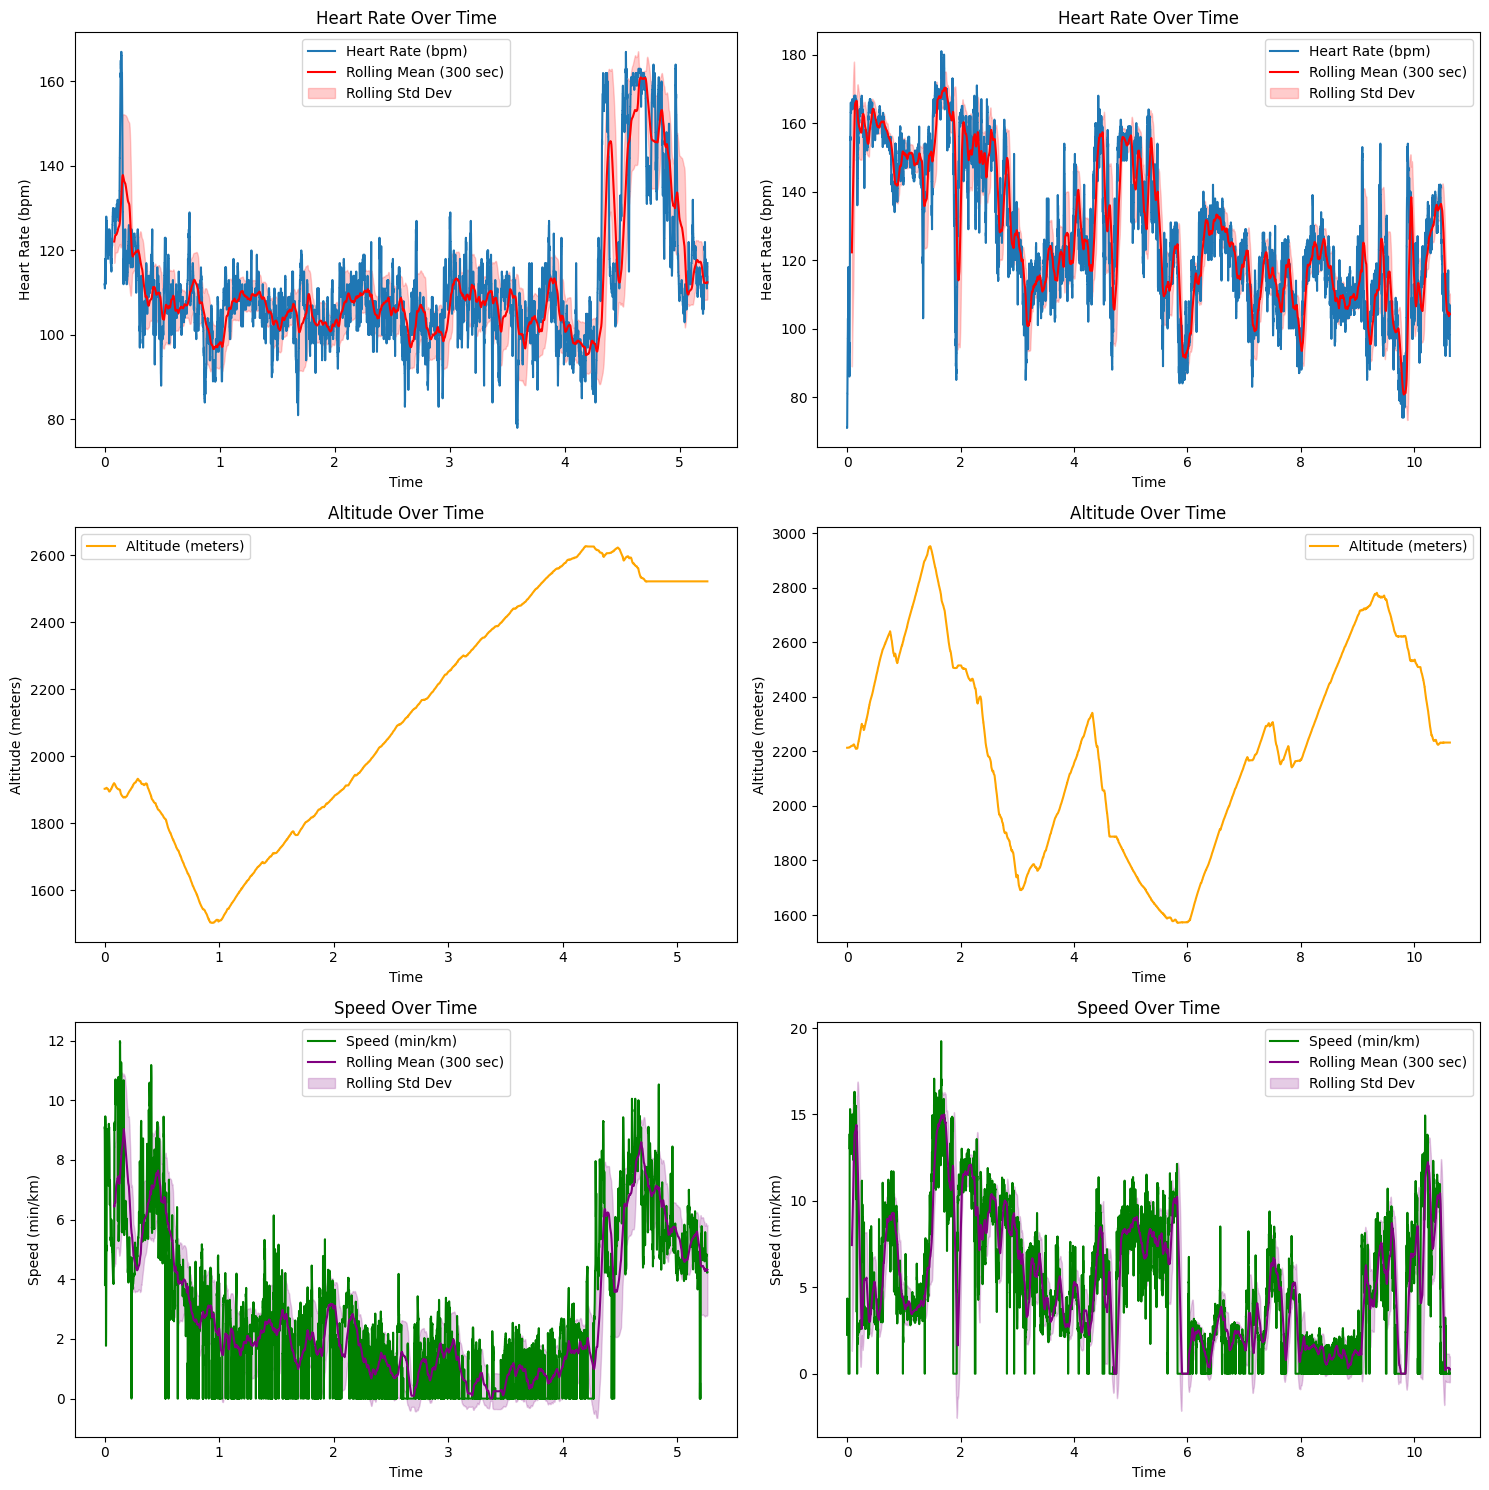

In [64]:
# Function to plot time series data for a single training session
def plot_time_series(df, axes):
    # Convert duration from seconds to hours for x-axis
    time_hours = df.index / 3600

    # Plot heart rate over time
    # Calculate rolling mean and standard deviation for heart rate
    hr_index = 0
    hr_window = 300
    hr_rolling_mean = df["heartRate"].rolling(window=hr_window).mean()
    hr_rolling_std = df["heartRate"].rolling(window=hr_window).std()
    axes[hr_index].plot(time_hours, df["heartRate"], label="Heart Rate (bpm)")
    axes[hr_index].plot(
        time_hours,
        hr_rolling_mean,
        label=f"Rolling Mean ({hr_window} sec)",
        color="red",
    )
    axes[hr_index].fill_between(
        time_hours,
        hr_rolling_mean - hr_rolling_std,
        hr_rolling_mean + hr_rolling_std,
        color="red",
        alpha=0.2,
        label="Rolling Std Dev",
    )
    axes[hr_index].set_title("Heart Rate Over Time")
    axes[hr_index].set_xlabel("Time")
    axes[hr_index].set_ylabel("Heart Rate (bpm)")
    axes[hr_index].legend()

    # Plot altitude over time
    a_index = 1
    axes[a_index].plot(
        time_hours, df["altitude"], label="Altitude (meters)", color="orange"
    )
    axes[a_index].set_title("Altitude Over Time")
    axes[a_index].set_xlabel("Time")
    axes[a_index].set_ylabel("Altitude (meters)")
    axes[a_index].legend()

    # Plot speed over time
    s_index = 2
    s_window = 300
    s_rolling_mean = df["speed"].rolling(window=s_window).mean()
    s_rolling_std = df["speed"].rolling(window=s_window).std()
    axes[s_index].plot(time_hours, df["speed"], label="Speed (min/km)", color="green")
    axes[s_index].plot(
        time_hours,
        s_rolling_mean,
        label=f"Rolling Mean ({hr_window} sec)",
        color="purple",
    )
    axes[s_index].fill_between(
        time_hours,
        s_rolling_mean - s_rolling_std,
        s_rolling_mean + s_rolling_std,
        color="purple",
        alpha=0.2,
        label="Rolling Std Dev",
    )
    axes[s_index].set_title("Speed Over Time")
    axes[s_index].set_xlabel("Time")
    axes[s_index].set_ylabel("Speed (min/km)")
    axes[s_index].legend()


# Create a 3x3 subplot figure and plot time series for 3 random files

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
# axes = axes.flatten()

for i, sample_df in enumerate(sample_data_frames[:2]):
    print(sample_df)
    # print(f"Plotting {file_path}")
    plot_time_series(sample_df, axes[:, i])

plt.tight_layout()
plt.show()

#### Observaciones:

Hay cierta correlación entre el ritmo cardíaco y la altura, que se recupera durante los planos bajada. No se aprecia una correlación directa entre la velocidad y la altura.

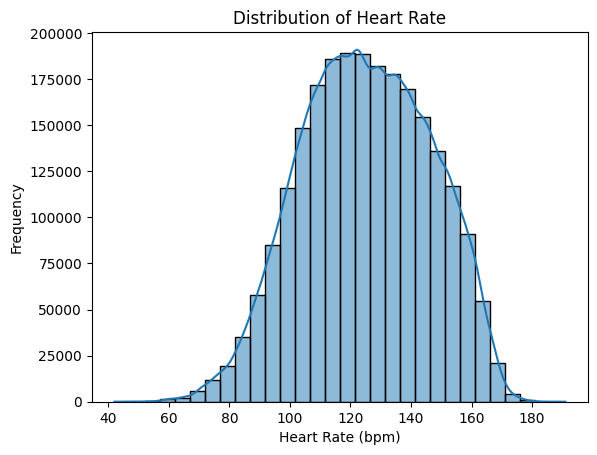

In [65]:
# Plot the distribution of heart rate
sns.histplot(data['heartRate'].dropna(), kde=True, bins=30)
plt.title('Distribution of Heart Rate')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Frequency')
plt.show()

#### Observaciones

La mayoría de los entrenamientos fueron en zona 1 y 2 (100 a 130 BPMs para el individuo de estudio) y zona 4 - 5 ( > 158 BPMs para el individuo de estudio), las competencias usualmente son en zona 5, por lo tanto tiene sentido que la mayoría de observaciones el ritmo cardíaco haya estado predominantemente alrededor de los 160 BPMs



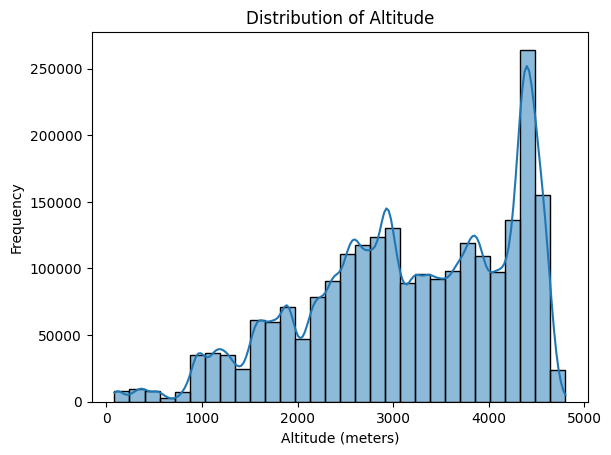

In [66]:
# Plot the distribution of altitude
sns.histplot(data['altitude'].dropna(), kde=True, bins=30)
plt.title('Distribution of Altitude')
plt.xlabel('Altitude (meters)')
plt.ylabel('Frequency')
plt.show()

#### Observaciones

Al residir en la ciudad de Quito, la mayoria de los entrenamientos largos fueron en altura a ~3000 metros de altura (Quito y sus alrededores principalmente) y ~4500 metros de altura (zona Integrales del Ruco Pichincha)

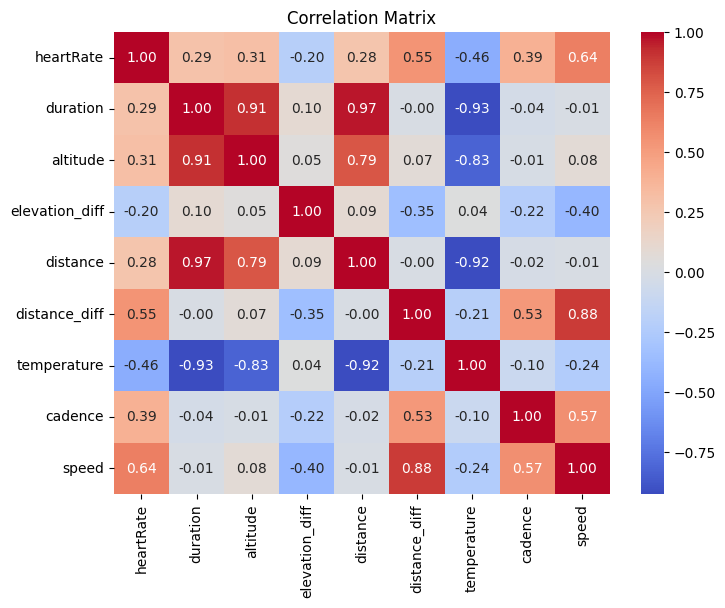

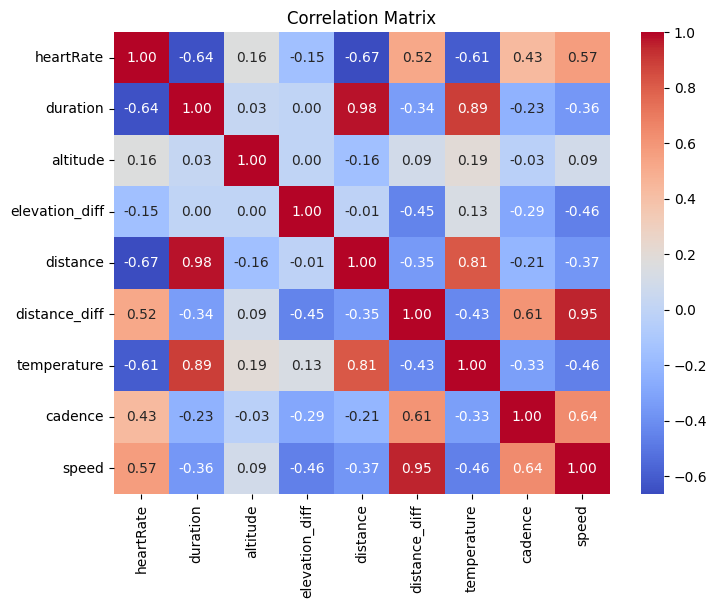

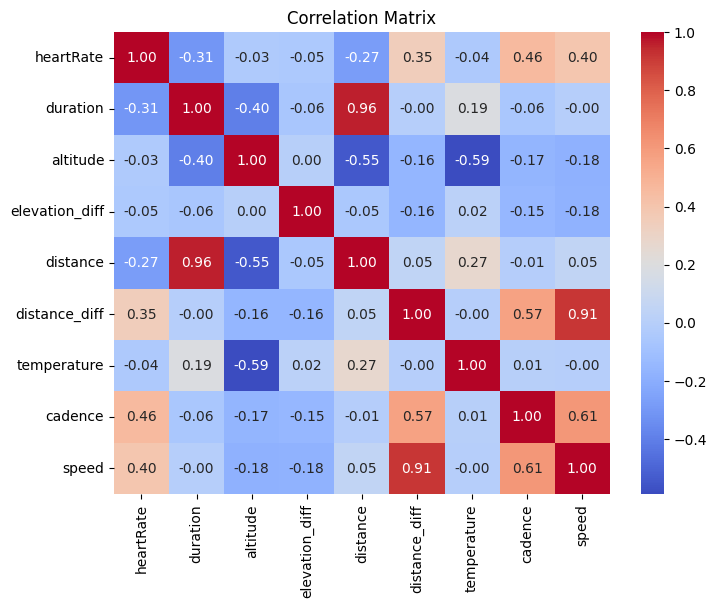

In [68]:
# Function to calculate and plot correlations between metrics
def plot_metric_correlations(df):
    # Calculate correlation matrix
    correlation_matrix = df.corr()

    # Plot heatmap of correlations
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

# Plot correlations for the first file in the directory
for i, sample_df in enumerate(sample_data_frames[:2]):
    plot_metric_correlations(sample_df.drop(columns=["timestamp", "date"]))

# Plot correlations for the aggregated dataframe
plot_metric_correlations(data.drop(columns=["timestamp", "date"]))


#### Observaciones

speed y distance_diff > alta correlacion

## Selección de modelo

En ésta sección se implementará una técnica de feature selection utilizando `SelectKBest` y `GroupTimeSeriesSplit`.

#### Feature Lags

Se cran feature lags sobre los primeros 30 mins

In [69]:
import math

# Create feature lags
def create_feature_lags(df, feature, lag=1, periods=1):
    """
    Create lagged features for a given feature in the DataFrame.
    """
    if periods == 1:
        df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
    else:
        df[f"{feature}_lag_{lag}"] = (
            df[feature]
            .shift(periods * (lag - 1) + 1)
            .rolling(window=periods)
            .mean()
        )
    # Fill NaN values with the mean of the feature
    df[f"{feature}_lag_{lag}"].fillna(df[feature].mean(), inplace=True)
    return df


# Create lagged features for heart rate, elevantion_diff, and distance_diff
data_lags = data.copy()
for lag in range(1, 31):
    data_lags = create_feature_lags(data_lags, "heartRate", lag, 60)
    data_lags = create_feature_lags(data_lags, "elevation_diff", lag, 60)
    data_lags = create_feature_lags(data_lags, "distance_diff", lag, 60)

# Check the dimensions of the new DataFrame
print(data_lags.shape)

(2338327, 101)


Luego de crear los feature lags, es necesario dividir el dataset en test y entrenamiento. En este caso los datos estan agrupados por cada uno de los entrenamientos pero también cada entrenamiento corresponde a un conjunto de series de tiempo por lo que se necesitan considerar los dos casos. La clase `GroupTimeSeriesSplit` de la libreria [`mlxtend`](https://rasbt.github.io/mlxtend/user_guide/evaluate/GroupTimeSeriesSplit/) implementa lo necesario para poder llevar a cabo este proceso

In [70]:
!pip install mlxtend --quiet

In [89]:
# Ensure there are no NaN values in the DataFrame. Fill with 0
data_lags.fillna(0, inplace=True)

# Divide by unique dates into test and train sets
# Keep the corresponding training session groups (Only 2025 will be used for ultimate evaluation)
X_train_val = data_lags[data_lags["date"] < "2025-01-01"]
X_test = data_lags[data_lags["date"] >= "2025-01-01"]

# Ensure the data is sorted by date and duration
X_train_val.sort_values(by=["date", "duration"], inplace=True)
X_test.sort_values(by=["date", "duration"], inplace=True)

<ipython-input-89-fd30941eede9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val.sort_values(by=["date", "duration"], inplace=True)
<ipython-input-89-fd30941eede9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.sort_values(by=["date", "duration"], inplace=True)


In [ ]:
from sklearn.datasets import make_regression
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from mlxtend.evaluate import GroupTimeSeriesSplit

# Extract X and y datasets for training
X = X_train_val.drop(columns=["timestamp", "date", "distance_diff"])
y = X_train_val["distance_diff"]
groups = X_train_val["date"]

# Group-aware time series split
# Set the test size to 20% of the unique groups
test_size = int(0.2 * len(groups.unique()))
cv_args = {"test_size": test_size, "n_splits": 1}
gtscv = GroupTimeSeriesSplit(**cv_args)

mean_scores = []

# Use the split generator from mlxtend
splits = list(gtscv.split(X, y, groups=groups))
# print(splits)

k_values = range(X.shape[1] - 30, X.shape[1] - 5)

for k in k_values:
    mse_scores = []

    for train_idx, val_idx in splits:
        
        # Split data
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        # Standardize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Feature selection
        selector = SelectKBest(score_func=f_regression, k=k)
        X_train_sel = selector.fit_transform(X_train, y_train)
        X_val_sel = selector.transform(X_val_scaled)

        # Train model
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train_sel, y_train)

    # Evaluate
    y_pred = model.predict(X_val_sel)
    mse = mean_squared_error(y_val, y_pred)
    mse_scores.append(mse)

/home/eaguayo/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


## Referencias

https://core.ac.uk/download/614520156.pdf
